In [30]:
import pandas as pd
import geopandas as gpd
import json
import math
from shapely.geometry import Polygon
from shapely.ops import split
from utils import *

In [31]:
#country border taken from https://www.kaggle.com/datasets/pompelmo/usa-states-geojson?resource=download
usa2 = gpd.read_file('data\\us-states.json')
ri= usa2[usa2['id'] == 'RI'] #selecting only Rhode Island border
#print(ri.crs)

In [32]:
rigis = gpd.read_file('data\Ponds_and_Lakes.geojson')
#print(rigis.crs)


In [33]:
dams=gpd.read_file('data\dams.geojson')
#print(dams.crs)


In [34]:
#  Since we are using two different data sources, to avoid having duplicates, I remove from
#  the less accurate data source ( because it reports lakes as points instead of polygons) the
#  data that are in the other source instead. This way I can then merge the two geodataframes without having duplicates.

dams['savedindex']= dams.index
intersecting = rigis.sjoin(dams, how='inner', predicate='intersects')['savedindex'] #Find the polygons that intersect. Keep savedindex as a series
print('# of lakes in dams wich are also in rigis:',intersecting.shape[0])
dams = dams[~dams.savedindex.isin(intersecting)]
all_lake=pd.concat([dams, rigis])


# of lakes in dams wich are also in rigis: 90


<AxesSubplot:>

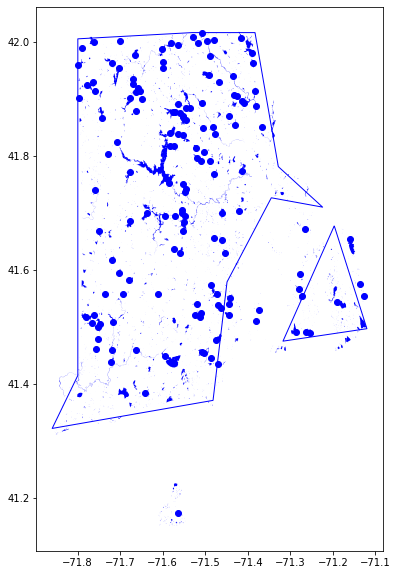

In [35]:
base = ri.plot(color='none', edgecolor='blue', figsize=(10,10))
all_lake.plot(ax=base, color='blue')


In [36]:
#  In this example to identify whether a lake is artificial or not I based on the
#  idea that if a lake is rectangular then it must be artificial, since in nature
#  it is almost impossible to find this shape. However, it is not a method that succeeds
#  in recognizing all artificial lakes since they are not necessarily rectangular in shape.
#  Assuming, however, that rectangular lakes are artificial, I made use of a shape index called
#  rectangularity, which basically says that: a polygon is a rectangle if its area coincides with
#  the area of its minimum bounded rectangle

#  At this index I set a range of 70% beyond which, the polygon is considered as a rectangle and therefore the lake as artificial.

def rectangle_similarity(poly):
    if (poly.area / poly.minimum_rotated_rectangle.area) > .80:
        return True

all_lake = all_lake[all_lake.geom_type != 'Point']
all_lake['artificial']=all_lake.apply(lambda row : rectangle_similarity(row.geometry),axis = 1)



C:\Users\stefb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(531, 101)


<AxesSubplot:>

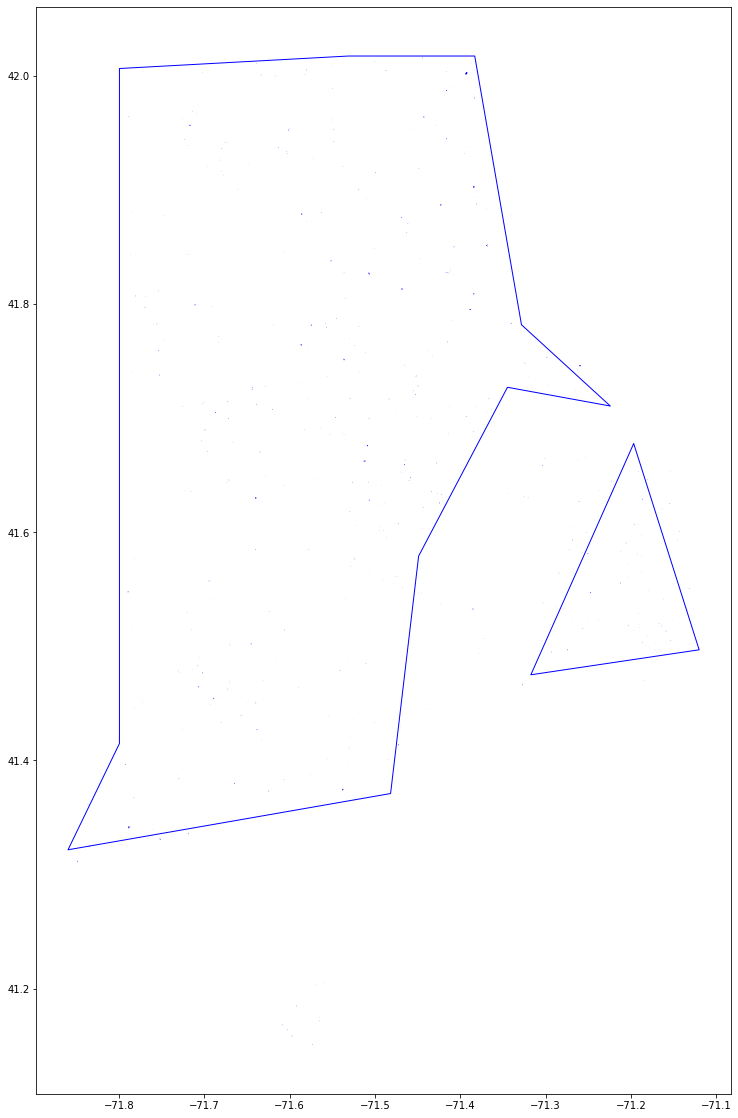

In [37]:
artificial_lake = all_lake[all_lake['artificial'] == True]
print(artificial_lake.shape)
base = ri.plot(color='none', edgecolor='blue',figsize=(20,20))
artificial_lake.plot(ax=base, color='blue')



In [42]:
lake_geom = all_lake['geometry']

all_lake['area']=lake_geom.to_crs({'proj':'cea'}).area/ 10**6 #km^2

df1=all_lake.nlargest(3,'area')
df2=all_lake.nsmallest(3,'area')
ex=pd.concat([df1, df2]) #dataframe containing 3 largest and 3 smallest lakes




In [45]:
# Since a few hundred items resulted in each collection the computation time took a long time,
# I tried as described here (Limit Section: https://github.com/sat-utils/sat-search/blob/master/tutorial-1.ipynb)
# to put a limit on the number of items returned within the function 'find_urls' line 32,
# but it did not work. For this, of each collection I take only the first item by doing 'collection[0]'.

bboxes=ex.bounds.apply(tuple, axis=1).tolist()
name_list=[]

for bbox in bboxes:
    collection=find_urls(bbox)
    img_name=fetch_image(bbox,collection[0])
    name_list.append(img_name)

name_list


There are more items found (409) than the limit (1) provided.


Starting for S2B_18TYM_20220820_0_L2A
success


There are more items found (869) than the limit (1) provided.


Starting for S2B_18TYL_20220820_0_L2A
success


There are more items found (409) than the limit (1) provided.


Starting for S2B_18TYM_20220820_0_L2A
success


There are more items found (468) than the limit (1) provided.


Starting for S2B_18TYL_20220820_0_L2A
success


There are more items found (468) than the limit (1) provided.


Starting for S2A_18TYL_20220825_0_L2A
success


There are more items found (468) than the limit (1) provided.


Starting for S2B_18TYL_20220820_0_L2A
success


['S2B_18TYM_20220820_0_L2A',
 'S2B_18TYL_20220820_0_L2A',
 'S2B_18TYM_20220820_0_L2A',
 'S2B_18TYL_20220820_0_L2A',
 'S2A_18TYL_20220825_0_L2A',
 'S2B_18TYL_20220820_0_L2A']

c:\Users\stefb\Documents\Glint Solar case\Glint Solar case\utils.py:129: RuntimeWarning: invalid value encountered in true_divide
  dat = dat / np.quantile(dat, 0.95)


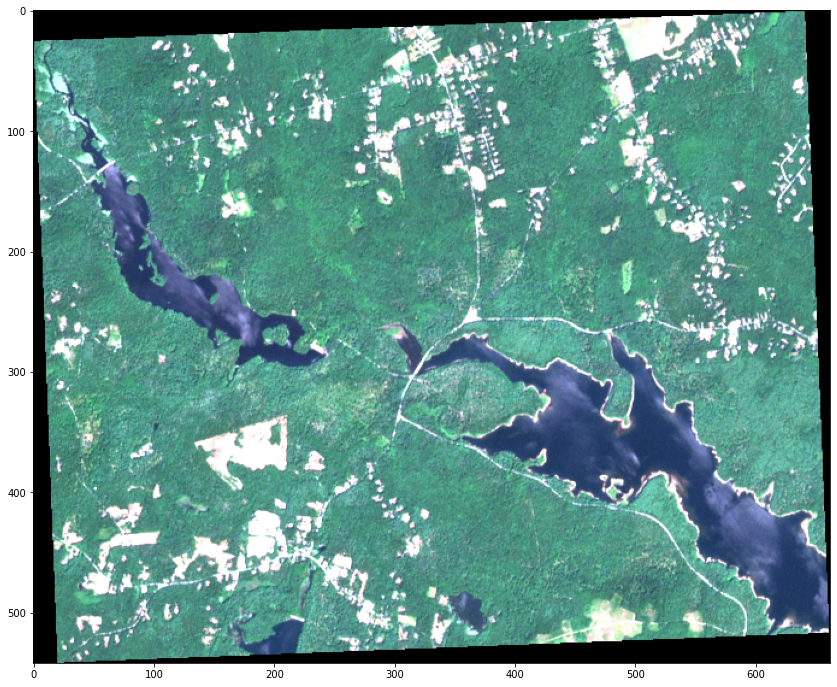

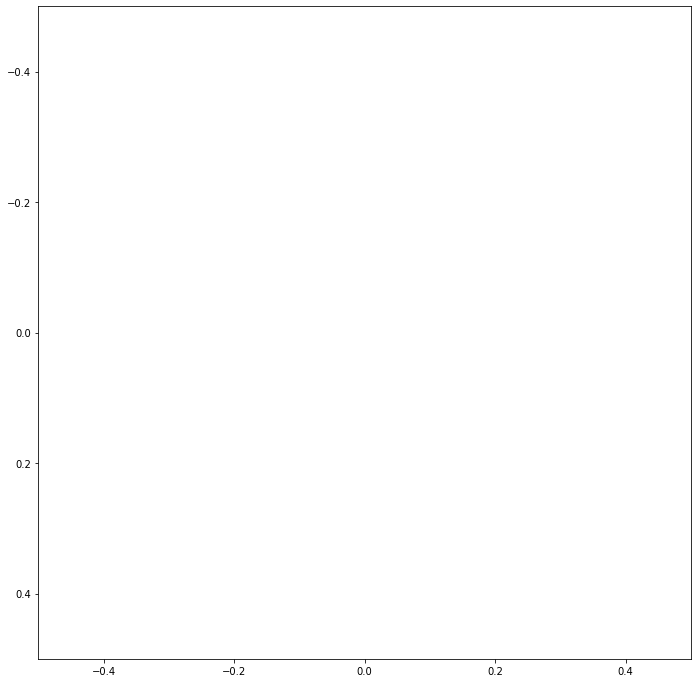

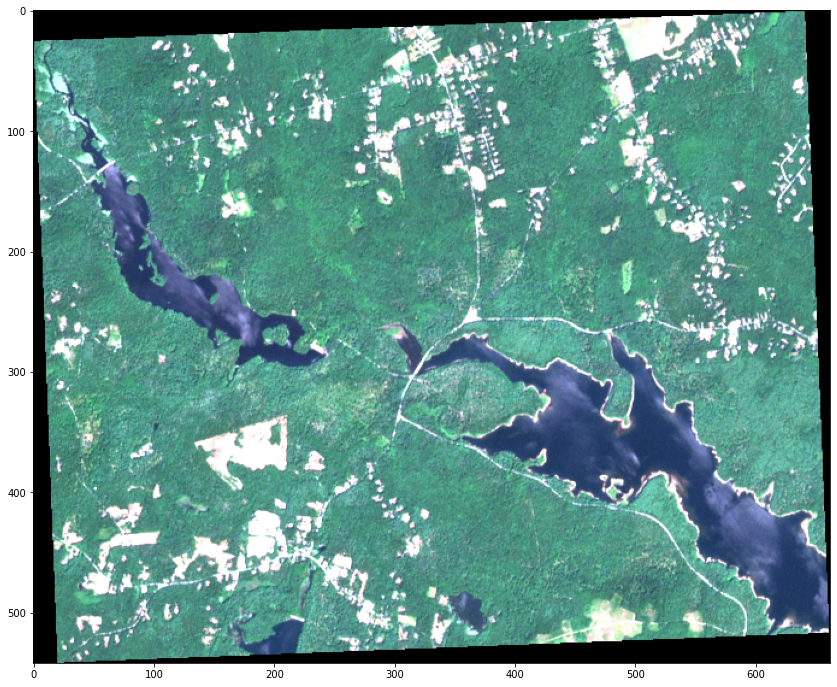

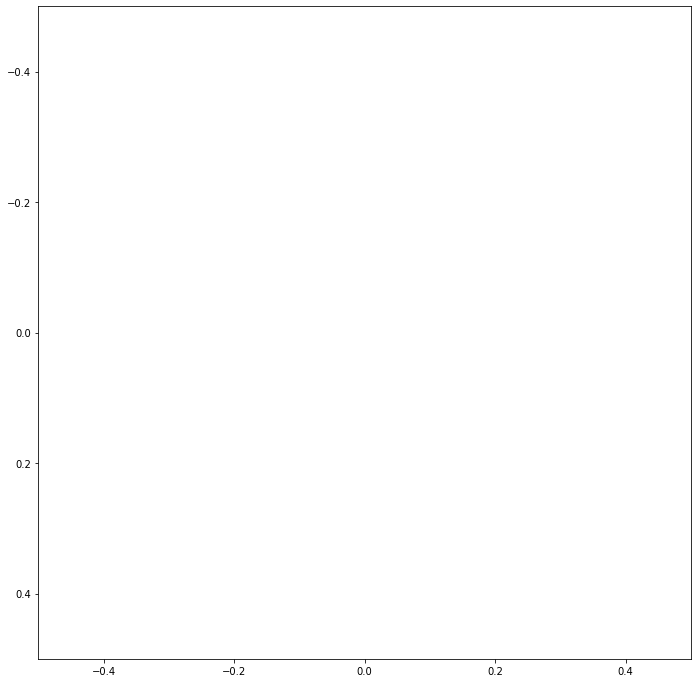

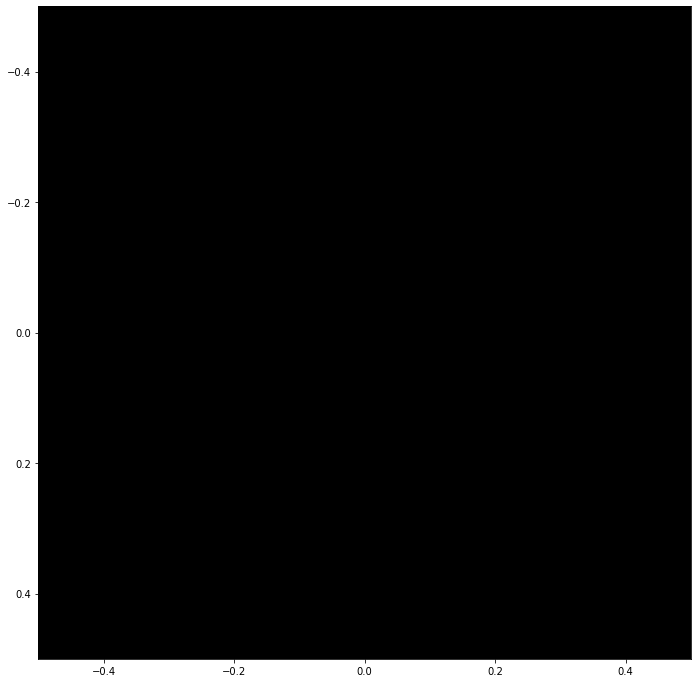

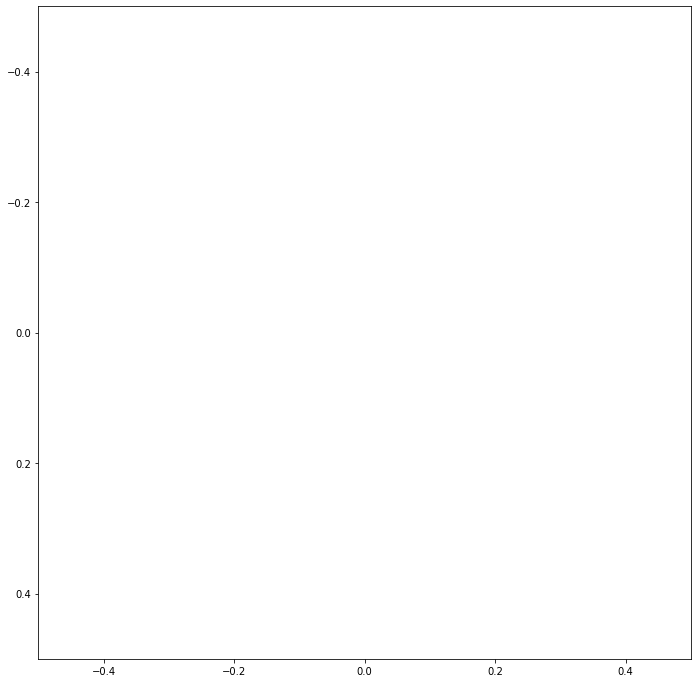

In [46]:
for i in name_list:
    rgbplot(i)